In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Dataset

In [2]:
DS_PATH = '../datasets/'

In [3]:
X_df = pd.read_csv(f"{DS_PATH}bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb.txt", sep=' ', header=None, names=['x', 'y', 'z', 'intensity', 'r', 'g', 'b'])

In [4]:
X_df.head()

,x,y,z,intensity,r,g,b
0,20.623,40.276,-1.999,-1031,127,141,154
1,20.362,40.375,-2.239,-941,130,141,159
2,20.360,40.376,-2.402,-1083,139,151,165
3,20.374,40.367,-2.405,-1122,131,147,163
4,20.372,40.366,-2.405,-1165,132,145,161


In [5]:
X_df.shape

(29697591, 7)

In [6]:
labels_df = pd.read_csv(f"{DS_PATH}sem8_labels_training/sem8_labels_training/bildstein_station1_xyz_intensity_rgb.labels", sep='\r\n', header=None, names=['label'], engine='python')

In [7]:
labels_df.head()

,label
0,0
1,0
2,6
3,0
4,0


In [8]:
labels_df.shape

(29697591, 1)

In [9]:
df = pd.concat([X_df, labels_df], axis=1)

df.head()

,x,y,z,intensity,r,g,b,label
0,20.623,40.276,-1.999,-1031,127,141,154,0
1,20.362,40.375,-2.239,-941,130,141,159,0
2,20.360,40.376,-2.402,-1083,139,151,165,6
3,20.374,40.367,-2.405,-1122,131,147,163,0
4,20.372,40.366,-2.405,-1165,132,145,161,0


## Data Cleaning

### Null Data

In [10]:
df.isnull().sum()

x            0
y            0
z            0
intensity    0
r            0
g            0
b            0
label        0
dtype: int64

### Duplicated Data

In [11]:
df.duplicated().sum()

1524

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

0

## Exploratory Data Analysis

### Target Label Distribution

Text(0, 0.5, 'Count (millions)')

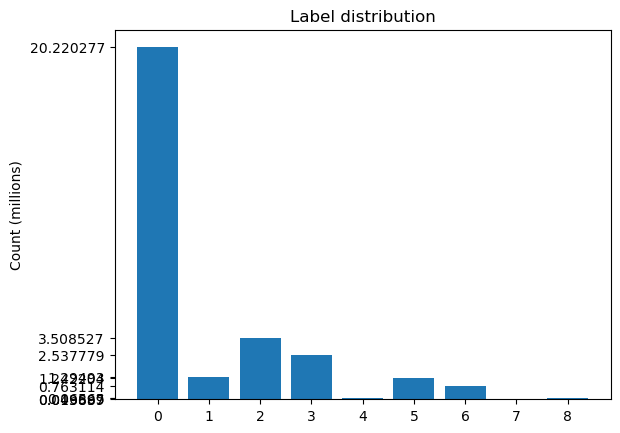

In [14]:
labels, counts = np.unique(df['label'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(labels, counts, align='center')
ax.set_xticks(labels)
ax.set_yticks(counts)
ax.set_yticklabels(counts / 1_000_000)
ax.set_title('Label distribution')
ax.set_ylabel('Count (millions)')

## PyTorch Dataset

In [15]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# Model